# Spatially Varying RNN
##### Tensorflow implementation based on https://faculty.ucmerced.edu/mhyang/papers/cvpr2018_dyanmic_scene_deblurring.pdf

If you want to just test the model, run only the cells under <strong> Miscellaneous tests </strong> section

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPool2D, LeakyReLU
import matplotlib.pyplot as plt
import tensorflow_addons as tfa
import os
import math
import matplotlib.pyplot as plt 
import numpy as np
import scipy.ndimage as ndimage

## Dataset Loading

In [2]:
image_dir_blur = "deblur detection/images/train/A/"
image_dir_clear = "deblur detection/images/train/B/"
image_paths_blur = os.listdir(image_dir_blur)
image_paths_clear = [image_dir_clear+path for path in image_paths_blur]
image_paths_blur = [image_dir_blur+path for path in image_paths_blur]

In [3]:
image_shape = (720, 1280)
every_n_image = 6
with tf.device("CPU:0"):
  # Load the data into memory
  blur_images = tf.zeros([1, *image_shape, 3], dtype="uint8")
  clear_images = tf.zeros([1, *image_shape, 3], dtype="uint8")
  for i in range(len(image_paths_clear)):
    
    blur_image_path = image_paths_blur[i*every_n_image]
    clear_image_path = image_paths_clear[i*every_n_image]
    
    blur_image = tf.image.decode_png(tf.io.read_file(blur_image_path))[tf.newaxis]
    blur_images = tf.concat([blur_image, blur_images], axis=0)

    clear_image = tf.image.decode_png(tf.io.read_file(clear_image_path))[tf.newaxis]
    clear_images = tf.concat([clear_image, clear_images], axis=0)

    if (i+1)%30==0:
      print("Retrieved %d images" % (i+1))
    
    if (i+1)*every_n_image>=len(image_paths_clear):
      break

Retrieved 30 images
Retrieved 60 images
Retrieved 90 images
Retrieved 120 images
Retrieved 150 images
Retrieved 180 images
Retrieved 210 images
Retrieved 240 images
Retrieved 270 images
Retrieved 300 images
Retrieved 330 images


## Creating the tensorflow dataset with image augmentation

In [4]:
# create the dataset
epoch_size = len(blur_images)

dataset = tf.data.Dataset.from_tensor_slices((blur_images, clear_images))
dataset = dataset.repeat().shuffle(epoch_size)

resize_shape = (128, 128)

height, width = clear_image.shape[1:3]
max_crop = min(height, width)

def random_rotate_image(blur_image, clear_image):
  angle = np.random.uniform(-30, 30)
  clear_image = ndimage.rotate(clear_image, angle, reshape=False)
  blur_image = ndimage.rotate(blur_image, angle, reshape=False)
  return blur_image, clear_image

def random_crop_image(blur_image, clear_image):
    random_value = np.random.choice(range(32, max_crop))
    height_random_value = np.random.choice(range(height-random_value))
    width_random_value = np.random.choice(range(width-random_value))

    out = tf.stack([blur_image, clear_image])

    out = out[:, height_random_value:(height_random_value+random_value), width_random_value:(width_random_value+random_value)]
    out = tf.image.resize(out, resize_shape)
    return out

def crop_and_resize_image(blur_image, clear_image):

  [out, ] = tf.py_function(random_crop_image, [blur_image, clear_image], [tf.float32])
  [blur_image, clear_image] = tf.py_function(random_rotate_image, [out[0], out[1]], [tf.float32, tf.float32])
  blur_image = 2*blur_image/255 - 1
  clear_image = 2*clear_image/255 - 1

  return blur_image, clear_image-blur_image

dataset = dataset.map(crop_and_resize_image, num_parallel_calls=4)
dataset = dataset.batch(14)
# try one of the following
dataset = dataset.prefetch(4)

In [5]:

for data in dataset:
  print(data[0].shape)
  break

%timeit -n 5 for data in dataset: break

(14, 128, 128, 3)
2.49 s ± 19.8 ms per loop (mean ± std. dev. of 7 runs, 5 loops each)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

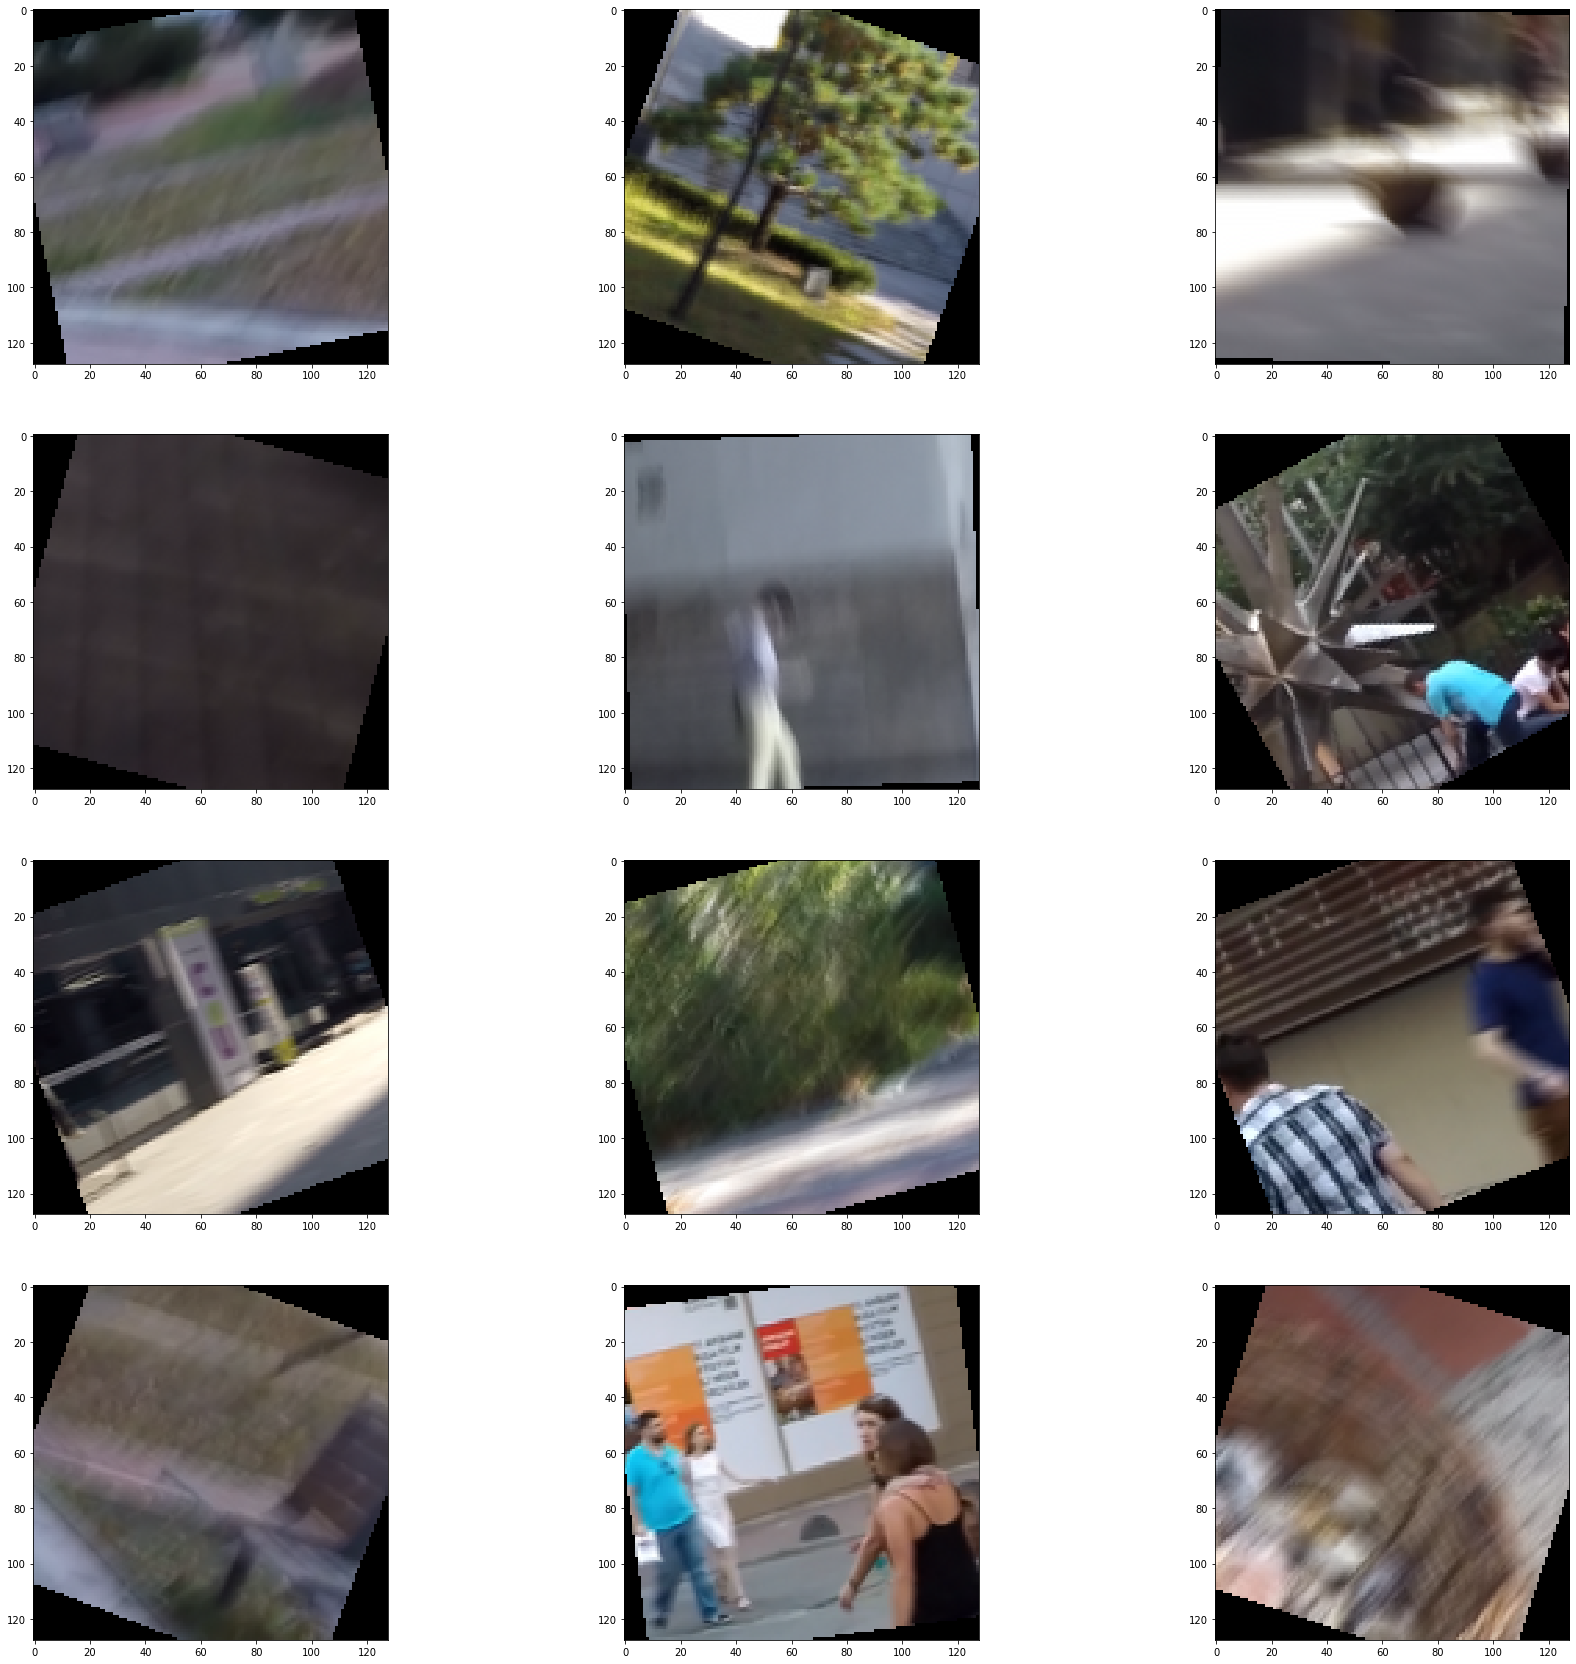

In [6]:
plt.figure()
plt.figure(figsize=(30.0, 30.0))
for i in range(12):
  plt.subplot(4, 3, i+1)
  plt.imshow((data[0][i])/2 + 0.5)
plt.show()

## Model

In [7]:
class WeightGenerator(tf.keras.layers.Layer):
    def __init__(self):
        super(WeightGenerator, self).__init__()
        self.vgg_layers = keras.applications.vgg16.VGG16(include_top=False).layers[:13]
        # for layer in self.vgg_layers[:8]:
        #   layer.trainable = False
        self.pool1 = MaxPool2D()
        self.pool2 = MaxPool2D()
        self.pool3 = MaxPool2D()
        self.conv12 = Conv2D(256, 3, padding="same")
        # Determine Resize 2 in build
        # Add the concatenation from conv8 in the call
        self.conv13 = Conv2D(128, 3, padding="same")
        self.conv14 = Conv2D(128, 3, padding="same")
        # Determine Resize 3 in build
        # Add the concatenation from conv6 in the call
        self.conv15 = Conv2D(128, 3, strides=2, padding="same")
        self.conv16 = Conv2D(512, 3, padding="same")
        
        # All the layers have ReLU function, except for the last layer where we use tanh
        
    # def build(self, input_shape):
    #     height, width = input_shape[1:3]
    #     self.resize2_size = tf.convert_to_tensor([(height//2)//2, (width//2)//2], dtype="int32")
    #     self.resize3_size = self.resize2_size * 2
    
    @tf.function
    def call(self, inputs):
        x = self.vgg_layers[1](inputs)
        x = tf.nn.relu(x)
        x = self.vgg_layers[2](x)
        x = tf.nn.relu(x)
        x = self.pool1(x)
        x = self.vgg_layers[4](x)
        x = tf.nn.relu(x)
        x = self.vgg_layers[5](x)
        x1 = tf.nn.relu(x)
        x = self.pool2(x1)
        x = self.vgg_layers[7](x)
        x = tf.nn.relu(x)
        x = self.vgg_layers[8](x)
        x2 = tf.nn.relu(x)
        x = self.vgg_layers[9](x)
        x = tf.nn.relu(x)
        x = self.pool3(x)
        x = self.vgg_layers[11](x)
        x = tf.nn.relu(x)
        x = self.vgg_layers[12](x)
        x = tf.nn.relu(x)

        x = self.conv12(x)
        x = tf.nn.relu(x)
        x = tf.image.resize(x, tf.convert_to_tensor(x.shape[1:3])*2)
        x = tf.concat([x, x2], axis=3)
        x = self.conv13(x)
        x = tf.nn.relu(x)
        x = self.conv14(x)
        x = tf.nn.relu(x)
        x = tf.image.resize(x, tf.convert_to_tensor(x.shape[1:3])*2)
        x = tf.concat([x, x1], axis=3)
        x = self.conv15(x)
        x = tf.nn.relu(x)
        x = self.conv16(x)
        x = tf.nn.tanh(x)
        return x

In [8]:
# The features should have depth hidden_vector_dimension. The features should have 2*hidden_vector_dimension. The first half is used for the height, and the second half for the width
class RNN_Spatial(tf.keras.layers.Layer):
  def __init__(self):
    super(RNN_Spatial, self).__init__()

  def build(self, input_shape):
    feature_shape, weight_shape = input_shape
    self.depth = feature_shape[3]
    self.height, self.width = feature_shape[1:3]
    # self.height, self.width = tf.convert_to_tensor(self.height), tf.convert_to_tensor(self.width)
  
  def height_forward(self, features, weights):
    hidden_vector = tf.zeros(self.depth)

    new_k = (1 - weights[:, 0, None, :, :]) * features[:, 0, None, :, :] + weights[:, 0, None, :, :]*hidden_vector
    for i in range(1, self.height):
      hidden_vector = (1 - weights[:, i, None, :, :]) * features[:, i, None, :, :] + weights[:, i, None, :, :]*hidden_vector
      new_k = tf.concat([new_k, hidden_vector], axis=1)
    return new_k

  # the features for this are different from the forward pass
  def height_backward(self, features, weights):
    hidden_vector = tf.zeros(self.depth)

    new_k = (1 - weights[:, self.height-1, None, :, :]) * features[:, self.height-1, None, :, :] + weights[:, self.height-1, None, :, :]*hidden_vector
    for i in range(1, self.height):
      hidden_vector = (1 - weights[:, self.height-i-1, None, :, :]) * features[:, self.height-i-1, None, :, :] + weights[:, self.height-i-1, None, :, :]*hidden_vector
      new_k = tf.concat([new_k, hidden_vector], axis=1)
    return new_k

  def width_forward(self, features, weights):
    hidden_vector = tf.zeros(self.depth)
    
    new_k = (1 - weights[:, :, None, 0, :]) * features[:, :, None, 0, :] + weights[:, :, None, 0, :]*hidden_vector
    for i in range(1, self.width):
      hidden_vector = (1 - weights[:, :, None, i, :]) * features[:, :, None, i, :] + weights[:, :, None, i, :]*hidden_vector
      new_k = tf.concat([new_k, hidden_vector], axis=2)
    return new_k

  def width_backward(self, features, weights):
    hidden_vector = tf.zeros(self.depth)
    
    new_k = (1 - weights[:, :, None, self.width-1, :]) * features[:, :, None, self.width-1, :] + weights[:, :, None, self.width-1, :]*hidden_vector
    for i in range(1, self.width):
      hidden_vector = (1 - weights[:, :, None, self.width-i-1, :]) * features[:, :, None, self.width-i-1, :] + weights[:, :, None, self.width-i-1, :]*hidden_vector
      new_k = tf.concat([new_k, hidden_vector], axis=2)
    return new_k

  @tf.function
  def call(self, inputs):
    features, weights = inputs

    self.height, self.width = features.shape[1:3]

    h_f = self.height_forward(features, weights[:, :, :, :self.depth])
    h_b = self.height_backward(features, weights[:, :, :, self.depth:2*self.depth])

    w_f = self.width_forward(features, weights[:, :, :, 2*self.depth:3*self.depth])
    w_b = self.width_backward(features, weights[:, :, :, 3*self.depth:4*self.depth])

    complete = tf.stack([h_f, h_b, w_f, w_b])
    out = tf.reduce_max(complete, axis=0)
    return out

In [9]:
class CompleteModel(tf.keras.Model):
  def __init__(self):
    super(CompleteModel, self).__init__()
    self.weight_generator = WeightGenerator()
    self.conv1 = Conv2D(16, 11, padding="same")
    self.conv2 = Conv2D(32, 7, strides=(2, 2), padding="same")
    self.conv_new_1 = Conv2D(32, 7, strides=(2, 2), padding="same")
    self.rnn_1 = RNN_Spatial()
    self.rnn_2 = RNN_Spatial()
    self.rnn_3 = RNN_Spatial()
    self.rnn_4 = RNN_Spatial()
    self.conv17 = Conv2D(32, 3, padding="same")
    self.conv18 = Conv2D(32, 3, padding="same")
    self.conv19 = Conv2D(32, 3, padding="same")
    self.conv20 = Conv2D(32, 3, padding="same")
    self.conv_new_2 = Conv2D(16, 7, padding="same")
    self.conv21 = Conv2D(16, 9, padding="same")
    self.conv22 = Conv2D(3, 5, padding="same")

  # def build(self, input_shape):
  #   height, width = input_shape[1:3]
  #   self.resize1 = tf.convert_to_tensor([height, width], dtype="int32")
  #   self.resize_new = self.resize1//2

  @ tf.function 
  def call(self, input_images):
    weights = self.weight_generator(input_images)
    x = self.conv1(input_images)
    x1 = tf.nn.leaky_relu(x, alpha=0.1)
    x = self.conv2(x1)
    x2 = tf.nn.leaky_relu(x, alpha=0.1)
    x = self.conv_new_1(x2)
    x3 = tf.nn.leaky_relu(x, alpha=0.1)

    x = self.rnn_1([x3, weights[:, :, :, :32*4]]) # x3 to switch back
    x = self.conv17(x)
    x = tf.nn.leaky_relu(x, alpha=0.1)
    x = self.rnn_2([x, weights[:, :, :, 32*4:32*8]])
    x = self.conv18(x)
    x = tf.nn.leaky_relu(x, alpha=0.1)
    x = self.rnn_3([x, weights[:, :, :, 32*8:32*12]])
    x = self.conv19(x)
    x = tf.nn.leaky_relu(x, alpha=0.1)
    x = self.rnn_4([x, weights[:, :, :, 32*12:32*16]])
    x = self.conv20(x)
    x = tf.nn.leaky_relu(x, alpha=0.1)

    x = tf.concat([x, x3], axis=3)
    x = self.conv_new_2(x)
    x = tf.nn.leaky_relu(x,  alpha=0.1)
    x = tf.image.resize(x, 2*tf.convert_to_tensor(x.shape[1:3]))

    x = tf.concat([x, x2], axis=3)
    x = self.conv21(x)
    x = tf.nn.leaky_relu(x, alpha=0.1)
    x = tf.image.resize(x, 2*tf.convert_to_tensor(x.shape[1:3]))


    x = tf.concat([x, x1], axis=3)
    x = self.conv22(x)
    return x

## Training

In [10]:
weight_path = "weights/weight_custom_0.3"
complete_model = CompleteModel()
complete_model.load_weights(weight_path)
optim = tf.keras.optimizers.Adam(0.0001, 0.9, 0.999, 1e-6)
test = complete_model(data[0])
params = complete_model.trainable_variables

In [11]:
@tf.function
def train_step(blur_clear):
  with tf.GradientTape() as tape:
    out = complete_model(blur_clear[0]) # blur_clear
    loss = tf.reduce_mean((out-blur_clear[1])**2) # blur_clear
    grads = tape.gradient(loss, params)
    optim.apply_gradients(zip(grads, params))
    return loss

def train():
  total_loss = 0
  for i, blur_clear in enumerate(dataset):
      total_loss += train_step(blur_clear)

      if (i+1)%10000==0:
        complete_model.save_weights("weights/weight_%d_%.4f" % (i+1, total_loss))
        print("saved weights to weights/weight_%d_%.4f" % (i+1, total_loss))

      if (i+1)%50==0:
        print("Epoch : %d Iteration %d loss : %.5f" % (i*20//epoch_size, i+1, total_loss))
        total_loss = 0

      if i==200000:
        break

      if i==0:
        print("Hooray! Off we go!")

In [12]:
with tf.device("GPU:0"):
    train()

Hooray! Off we go!
Epoch : 2 Iteration 50 loss : 0.32149
Epoch : 5 Iteration 100 loss : 0.30447
Epoch : 8 Iteration 150 loss : 0.30481
Epoch : 11 Iteration 200 loss : 0.33340
Epoch : 14 Iteration 250 loss : 0.31373
Epoch : 16 Iteration 300 loss : 0.31909
Epoch : 19 Iteration 350 loss : 0.30808
Epoch : 22 Iteration 400 loss : 0.32929
Epoch : 25 Iteration 450 loss : 0.30669
Epoch : 28 Iteration 500 loss : 0.32101
Epoch : 31 Iteration 550 loss : 0.30271
Epoch : 34 Iteration 600 loss : 0.32109
Epoch : 36 Iteration 650 loss : 0.30326
Epoch : 39 Iteration 700 loss : 0.34759
Epoch : 42 Iteration 750 loss : 0.30878
Epoch : 45 Iteration 800 loss : 0.30834
Epoch : 48 Iteration 850 loss : 0.28941
Epoch : 51 Iteration 900 loss : 0.31701
Epoch : 53 Iteration 950 loss : 0.30753
Epoch : 56 Iteration 1000 loss : 0.31754
Epoch : 59 Iteration 1050 loss : 0.32886
Epoch : 62 Iteration 1100 loss : 0.28098
Epoch : 65 Iteration 1150 loss : 0.30155
Epoch : 68 Iteration 1200 loss : 0.30517
Epoch : 70 Iteration

Epoch : 559 Iteration 9850 loss : 0.33319
Epoch : 562 Iteration 9900 loss : 0.31000
Epoch : 565 Iteration 9950 loss : 0.30675
saved weights to weights/weight_10000_0.3247
Epoch : 568 Iteration 10000 loss : 0.32471
Epoch : 570 Iteration 10050 loss : 0.29029
Epoch : 573 Iteration 10100 loss : 0.32145
Epoch : 576 Iteration 10150 loss : 0.33477
Epoch : 579 Iteration 10200 loss : 0.33091
Epoch : 582 Iteration 10250 loss : 0.31462
Epoch : 585 Iteration 10300 loss : 0.36644
Epoch : 588 Iteration 10350 loss : 0.29930
Epoch : 590 Iteration 10400 loss : 0.31002
Epoch : 593 Iteration 10450 loss : 0.31459
Epoch : 596 Iteration 10500 loss : 0.31825
Epoch : 599 Iteration 10550 loss : 0.31040
Epoch : 602 Iteration 10600 loss : 0.32091
Epoch : 605 Iteration 10650 loss : 0.31037
Epoch : 607 Iteration 10700 loss : 0.29707
Epoch : 610 Iteration 10750 loss : 0.32925
Epoch : 613 Iteration 10800 loss : 0.30668
Epoch : 616 Iteration 10850 loss : 0.34054
Epoch : 619 Iteration 10900 loss : 0.31843
Epoch : 622 

Epoch : 1096 Iteration 19300 loss : 0.32415
Epoch : 1099 Iteration 19350 loss : 0.30643
Epoch : 1102 Iteration 19400 loss : 0.33100
Epoch : 1105 Iteration 19450 loss : 0.30754
Epoch : 1107 Iteration 19500 loss : 0.31616
Epoch : 1110 Iteration 19550 loss : 0.29831
Epoch : 1113 Iteration 19600 loss : 0.30581
Epoch : 1116 Iteration 19650 loss : 0.31577
Epoch : 1119 Iteration 19700 loss : 0.32174
Epoch : 1122 Iteration 19750 loss : 0.30570
Epoch : 1124 Iteration 19800 loss : 0.28942
Epoch : 1127 Iteration 19850 loss : 0.30515
Epoch : 1130 Iteration 19900 loss : 0.30862
Epoch : 1133 Iteration 19950 loss : 0.30322
saved weights to weights/weight_20000_0.3148
Epoch : 1136 Iteration 20000 loss : 0.31482
Epoch : 1139 Iteration 20050 loss : 0.30912
Epoch : 1141 Iteration 20100 loss : 0.30029
Epoch : 1144 Iteration 20150 loss : 0.33326
Epoch : 1147 Iteration 20200 loss : 0.31834
Epoch : 1150 Iteration 20250 loss : 0.31986
Epoch : 1153 Iteration 20300 loss : 0.30518
Epoch : 1156 Iteration 20350 lo

Epoch : 1624 Iteration 28600 loss : 0.30883
Epoch : 1627 Iteration 28650 loss : 0.31190
Epoch : 1630 Iteration 28700 loss : 0.34747
Epoch : 1633 Iteration 28750 loss : 0.29408
Epoch : 1636 Iteration 28800 loss : 0.29794
Epoch : 1639 Iteration 28850 loss : 0.31593
Epoch : 1641 Iteration 28900 loss : 0.30408
Epoch : 1644 Iteration 28950 loss : 0.30843
Epoch : 1647 Iteration 29000 loss : 0.32609
Epoch : 1650 Iteration 29050 loss : 0.30613
Epoch : 1653 Iteration 29100 loss : 0.29781
Epoch : 1656 Iteration 29150 loss : 0.29853
Epoch : 1659 Iteration 29200 loss : 0.32377
Epoch : 1661 Iteration 29250 loss : 0.26682
Epoch : 1664 Iteration 29300 loss : 0.30356
Epoch : 1667 Iteration 29350 loss : 0.28938
Epoch : 1670 Iteration 29400 loss : 0.30517
Epoch : 1673 Iteration 29450 loss : 0.30144
Epoch : 1676 Iteration 29500 loss : 0.31076
Epoch : 1678 Iteration 29550 loss : 0.29734
Epoch : 1681 Iteration 29600 loss : 0.30073
Epoch : 1684 Iteration 29650 loss : 0.30669
Epoch : 1687 Iteration 29700 los

Epoch : 2153 Iteration 37900 loss : 0.28958
Epoch : 2156 Iteration 37950 loss : 0.28165
Epoch : 2159 Iteration 38000 loss : 0.31673
Epoch : 2161 Iteration 38050 loss : 0.30983
Epoch : 2164 Iteration 38100 loss : 0.30113
Epoch : 2167 Iteration 38150 loss : 0.30819
Epoch : 2170 Iteration 38200 loss : 0.29877
Epoch : 2173 Iteration 38250 loss : 0.28574
Epoch : 2176 Iteration 38300 loss : 0.29552
Epoch : 2178 Iteration 38350 loss : 0.29828
Epoch : 2181 Iteration 38400 loss : 0.29306
Epoch : 2184 Iteration 38450 loss : 0.32692
Epoch : 2187 Iteration 38500 loss : 0.30079
Epoch : 2190 Iteration 38550 loss : 0.28549
Epoch : 2193 Iteration 38600 loss : 0.30199
Epoch : 2195 Iteration 38650 loss : 0.32051
Epoch : 2198 Iteration 38700 loss : 0.31718
Epoch : 2201 Iteration 38750 loss : 0.31267
Epoch : 2204 Iteration 38800 loss : 0.29004
Epoch : 2207 Iteration 38850 loss : 0.30521
Epoch : 2210 Iteration 38900 loss : 0.30695
Epoch : 2213 Iteration 38950 loss : 0.31240
Epoch : 2215 Iteration 39000 los

Epoch : 2681 Iteration 47200 loss : 0.31196
Epoch : 2684 Iteration 47250 loss : 0.29692
Epoch : 2687 Iteration 47300 loss : 0.30069
Epoch : 2690 Iteration 47350 loss : 0.29017
Epoch : 2693 Iteration 47400 loss : 0.29787
Epoch : 2695 Iteration 47450 loss : 0.30349
Epoch : 2698 Iteration 47500 loss : 0.31471
Epoch : 2701 Iteration 47550 loss : 0.29218
Epoch : 2704 Iteration 47600 loss : 0.28533
Epoch : 2707 Iteration 47650 loss : 0.34428
Epoch : 2710 Iteration 47700 loss : 0.31443
Epoch : 2713 Iteration 47750 loss : 0.33288
Epoch : 2715 Iteration 47800 loss : 0.29474
Epoch : 2718 Iteration 47850 loss : 0.30206
Epoch : 2721 Iteration 47900 loss : 0.29656
Epoch : 2724 Iteration 47950 loss : 0.31973
Epoch : 2727 Iteration 48000 loss : 0.28939
Epoch : 2730 Iteration 48050 loss : 0.30205
Epoch : 2732 Iteration 48100 loss : 0.30433
Epoch : 2735 Iteration 48150 loss : 0.28823
Epoch : 2738 Iteration 48200 loss : 0.29919
Epoch : 2741 Iteration 48250 loss : 0.30338
Epoch : 2744 Iteration 48300 los

Epoch : 3210 Iteration 56500 loss : 0.29775
Epoch : 3213 Iteration 56550 loss : 0.29022
Epoch : 3215 Iteration 56600 loss : 0.27788
Epoch : 3218 Iteration 56650 loss : 0.30667
Epoch : 3221 Iteration 56700 loss : 0.28970
Epoch : 3224 Iteration 56750 loss : 0.31140
Epoch : 3227 Iteration 56800 loss : 0.29938
Epoch : 3230 Iteration 56850 loss : 0.30953
Epoch : 3232 Iteration 56900 loss : 0.27612
Epoch : 3235 Iteration 56950 loss : 0.30411
Epoch : 3238 Iteration 57000 loss : 0.32603
Epoch : 3241 Iteration 57050 loss : 0.32767
Epoch : 3244 Iteration 57100 loss : 0.30284
Epoch : 3247 Iteration 57150 loss : 0.30883
Epoch : 3249 Iteration 57200 loss : 0.32726
Epoch : 3252 Iteration 57250 loss : 0.31738
Epoch : 3255 Iteration 57300 loss : 0.29691
Epoch : 3258 Iteration 57350 loss : 0.29439
Epoch : 3261 Iteration 57400 loss : 0.31164
Epoch : 3264 Iteration 57450 loss : 0.26842
Epoch : 3266 Iteration 57500 loss : 0.31059
Epoch : 3269 Iteration 57550 loss : 0.29906
Epoch : 3272 Iteration 57600 los

Epoch : 3738 Iteration 65800 loss : 0.29480
Epoch : 3741 Iteration 65850 loss : 0.30604
Epoch : 3744 Iteration 65900 loss : 0.28475
Epoch : 3747 Iteration 65950 loss : 0.30173
Epoch : 3749 Iteration 66000 loss : 0.29554
Epoch : 3752 Iteration 66050 loss : 0.29640
Epoch : 3755 Iteration 66100 loss : 0.27066
Epoch : 3758 Iteration 66150 loss : 0.28462
Epoch : 3761 Iteration 66200 loss : 0.30462
Epoch : 3764 Iteration 66250 loss : 0.28971
Epoch : 3766 Iteration 66300 loss : 0.29689
Epoch : 3769 Iteration 66350 loss : 0.28566
Epoch : 3772 Iteration 66400 loss : 0.28899
Epoch : 3775 Iteration 66450 loss : 0.31575
Epoch : 3778 Iteration 66500 loss : 0.29508
Epoch : 3781 Iteration 66550 loss : 0.31108
Epoch : 3784 Iteration 66600 loss : 0.28141
Epoch : 3786 Iteration 66650 loss : 0.30018
Epoch : 3789 Iteration 66700 loss : 0.32315
Epoch : 3792 Iteration 66750 loss : 0.32602
Epoch : 3795 Iteration 66800 loss : 0.30939
Epoch : 3798 Iteration 66850 loss : 0.29628
Epoch : 3801 Iteration 66900 los

Epoch : 4266 Iteration 75100 loss : 0.27869
Epoch : 4269 Iteration 75150 loss : 0.29194
Epoch : 4272 Iteration 75200 loss : 0.27304
Epoch : 4275 Iteration 75250 loss : 0.31277
Epoch : 4278 Iteration 75300 loss : 0.28543
Epoch : 4281 Iteration 75350 loss : 0.29265
Epoch : 4284 Iteration 75400 loss : 0.30000
Epoch : 4286 Iteration 75450 loss : 0.28043
Epoch : 4289 Iteration 75500 loss : 0.34290
Epoch : 4292 Iteration 75550 loss : 0.29213
Epoch : 4295 Iteration 75600 loss : 0.29983
Epoch : 4298 Iteration 75650 loss : 0.27645
Epoch : 4301 Iteration 75700 loss : 0.29792
Epoch : 4303 Iteration 75750 loss : 0.28455
Epoch : 4306 Iteration 75800 loss : 0.29765
Epoch : 4309 Iteration 75850 loss : 0.31119
Epoch : 4312 Iteration 75900 loss : 0.31449
Epoch : 4315 Iteration 75950 loss : 0.29353
Epoch : 4318 Iteration 76000 loss : 0.30296
Epoch : 4320 Iteration 76050 loss : 0.30172
Epoch : 4323 Iteration 76100 loss : 0.29427
Epoch : 4326 Iteration 76150 loss : 0.28762
Epoch : 4329 Iteration 76200 los

KeyboardInterrupt: 

# Miscellaneous Tests

In [8]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPool2D, LeakyReLU
import matplotlib.pyplot as plt
import tensorflow_addons as tfa
import os
import math
import matplotlib.pyplot as plt 
import numpy as np
import scipy.ndimage as ndimage
import cv2

In [9]:
class WeightGenerator(tf.keras.layers.Layer):
    def __init__(self):
        super(WeightGenerator, self).__init__()
        self.vgg_layers = keras.applications.vgg16.VGG16(include_top=False).layers[:13]
        # for layer in self.vgg_layers[:8]:
        #   layer.trainable = False
        self.pool1 = MaxPool2D()
        self.pool2 = MaxPool2D()
        self.pool3 = MaxPool2D()
        self.conv12 = Conv2D(256, 3, padding="same")
        # Determine Resize 2 in build
        # Add the concatenation from conv8 in the call
        self.conv13 = Conv2D(128, 3, padding="same")
        self.conv14 = Conv2D(128, 3, padding="same")
        # Determine Resize 3 in build
        # Add the concatenation from conv6 in the call
        self.conv15 = Conv2D(128, 3, strides=2, padding="same")
        self.conv16 = Conv2D(512, 3, padding="same")
        
        # All the layers have ReLU function, except for the last layer where we use tanh
        
    # def build(self, input_shape):
    #     height, width = input_shape[1:3]
    #     self.resize2_size = tf.convert_to_tensor([(height//2)//2, (width//2)//2], dtype="int32")
    #     self.resize3_size = self.resize2_size * 2
    
    def call(self, inputs):
        x = self.vgg_layers[1](inputs)
        x = tf.nn.relu(x)
        x = self.vgg_layers[2](x)
        x = tf.nn.relu(x)
        x = self.pool1(x)
        x = self.vgg_layers[4](x)
        x = tf.nn.relu(x)
        x = self.vgg_layers[5](x)
        x1 = tf.nn.relu(x)
        x = self.pool2(x1)
        x = self.vgg_layers[7](x)
        x = tf.nn.relu(x)
        x = self.vgg_layers[8](x)
        x2 = tf.nn.relu(x)
        x = self.vgg_layers[9](x)
        x = tf.nn.relu(x)
        x = self.pool3(x)
        x = self.vgg_layers[11](x)
        x = tf.nn.relu(x)
        x = self.vgg_layers[12](x)
        x = tf.nn.relu(x)

        x = self.conv12(x)
        x = tf.nn.relu(x)
        x = tf.image.resize(x, tf.convert_to_tensor(x.shape[1:3])*2)
        x = tf.concat([x, x2], axis=3)
        x = self.conv13(x)
        x = tf.nn.relu(x)
        x = self.conv14(x)
        x = tf.nn.relu(x)
        x = tf.image.resize(x, tf.convert_to_tensor(x.shape[1:3])*2)
        x = tf.concat([x, x1], axis=3)
        x = self.conv15(x)
        x = tf.nn.relu(x)
        x = self.conv16(x)
        x = tf.nn.tanh(x)
        return x

In [10]:
# The features should have depth hidden_vector_dimension. The features should have 2*hidden_vector_dimension. The first half is used for the height, and the second half for the width
class RNN_Spatial(tf.keras.layers.Layer):
  def __init__(self):
    super(RNN_Spatial, self).__init__()

  def build(self, input_shape):
    feature_shape, weight_shape = input_shape
    self.depth = feature_shape[3]
    self.height, self.width = feature_shape[1:3]
    # self.height, self.width = tf.convert_to_tensor(self.height), tf.convert_to_tensor(self.width)
  
  def height_forward(self, features, weights):
    hidden_vector = tf.zeros(self.depth)

    new_k = (1 - weights[:, 0, None, :, :]) * features[:, 0, None, :, :] + weights[:, 0, None, :, :]*hidden_vector
    for i in range(1, self.height):
      hidden_vector = (1 - weights[:, i, None, :, :]) * features[:, i, None, :, :] + weights[:, i, None, :, :]*hidden_vector
      new_k = tf.concat([new_k, hidden_vector], axis=1)
    return new_k

  # the features for this are different from the forward pass
  def height_backward(self, features, weights):
    hidden_vector = tf.zeros(self.depth)

    new_k = (1 - weights[:, self.height-1, None, :, :]) * features[:, self.height-1, None, :, :] + weights[:, self.height-1, None, :, :]*hidden_vector
    for i in range(1, self.height):
      hidden_vector = (1 - weights[:, self.height-i-1, None, :, :]) * features[:, self.height-i-1, None, :, :] + weights[:, self.height-i-1, None, :, :]*hidden_vector
      new_k = tf.concat([new_k, hidden_vector], axis=1)
    return new_k

  def width_forward(self, features, weights):
    hidden_vector = tf.zeros(self.depth)
    
    new_k = (1 - weights[:, :, None, 0, :]) * features[:, :, None, 0, :] + weights[:, :, None, 0, :]*hidden_vector
    for i in range(1, self.width):
      hidden_vector = (1 - weights[:, :, None, i, :]) * features[:, :, None, i, :] + weights[:, :, None, i, :]*hidden_vector
      new_k = tf.concat([new_k, hidden_vector], axis=2)
    return new_k

  def width_backward(self, features, weights):
    hidden_vector = tf.zeros(self.depth)
    
    new_k = (1 - weights[:, :, None, self.width-1, :]) * features[:, :, None, self.width-1, :] + weights[:, :, None, self.width-1, :]*hidden_vector
    for i in range(1, self.width):
      hidden_vector = (1 - weights[:, :, None, self.width-i-1, :]) * features[:, :, None, self.width-i-1, :] + weights[:, :, None, self.width-i-1, :]*hidden_vector
      new_k = tf.concat([new_k, hidden_vector], axis=2)
    return new_k

  def call(self, inputs):
    features, weights = inputs

    self.height, self.width = features.shape[1:3]

    h_f = self.height_forward(features, weights[:, :, :, :self.depth])
    h_b = self.height_backward(features, weights[:, :, :, self.depth:2*self.depth])

    w_f = self.width_forward(features, weights[:, :, :, 2*self.depth:3*self.depth])
    w_b = self.width_backward(features, weights[:, :, :, 3*self.depth:4*self.depth])

    complete = tf.stack([h_f, h_b, w_f, w_b])
    out = tf.reduce_max(complete, axis=0)
    return out

In [11]:
class CompleteModel(tf.keras.Model):
  def __init__(self):
    super(CompleteModel, self).__init__()
    self.weight_generator = WeightGenerator()
    self.conv1 = Conv2D(16, 11, padding="same")
    self.conv2 = Conv2D(32, 7, strides=(2, 2), padding="same")
    self.conv_new_1 = Conv2D(32, 7, strides=(2, 2), padding="same")
    self.rnn_1 = RNN_Spatial()
    self.rnn_2 = RNN_Spatial()
    self.rnn_3 = RNN_Spatial()
    self.rnn_4 = RNN_Spatial()
    self.conv17 = Conv2D(32, 3, padding="same")
    self.conv18 = Conv2D(32, 3, padding="same")
    self.conv19 = Conv2D(32, 3, padding="same")
    self.conv20 = Conv2D(32, 3, padding="same")
    self.conv_new_2 = Conv2D(16, 7, padding="same")
    self.conv21 = Conv2D(16, 9, padding="same")
    self.conv22 = Conv2D(3, 5, padding="same")

  # def build(self, input_shape):
  #   height, width = input_shape[1:3]
  #   self.resize1 = tf.convert_to_tensor([height, width], dtype="int32")
  #   self.resize_new = self.resize1//2

  def call(self, input_images):
    weights = self.weight_generator(input_images)
    x = self.conv1(input_images)
    x1 = tf.nn.leaky_relu(x, alpha=0.1)
    x = self.conv2(x1)
    x2 = tf.nn.leaky_relu(x, alpha=0.1)
    x = self.conv_new_1(x2)
    x3 = tf.nn.leaky_relu(x, alpha=0.1)

    x = self.rnn_1([x3, weights[:, :, :, :32*4]]) # x3 to switch back
    x = self.conv17(x)
    x = tf.nn.leaky_relu(x, alpha=0.1)
    x = self.rnn_2([x, weights[:, :, :, 32*4:32*8]])
    x = self.conv18(x)
    x = tf.nn.leaky_relu(x, alpha=0.1)
    x = self.rnn_3([x, weights[:, :, :, 32*8:32*12]])
    x = self.conv19(x)
    x = tf.nn.leaky_relu(x, alpha=0.1)
    x = self.rnn_4([x, weights[:, :, :, 32*12:32*16]])
    x = self.conv20(x)
    x = tf.nn.leaky_relu(x, alpha=0.1)

    x = tf.concat([x, x3], axis=3)
    x = self.conv_new_2(x)
    x = tf.nn.leaky_relu(x,  alpha=0.1)
    x = tf.image.resize(x, 2*tf.convert_to_tensor(x.shape[1:3]))

    x = tf.concat([x, x2], axis=3)
    x = self.conv21(x)
    x = tf.nn.leaky_relu(x, alpha=0.1)
    x = tf.image.resize(x, 2*tf.convert_to_tensor(x.shape[1:3]))


    x = tf.concat([x, x1], axis=3)
    x = self.conv22(x)
    return x

In [12]:
with tf.device("CPU:0"):
    weight_path = "weights/weight_custom_0.3"
    complete_model = CompleteModel()
    complete_model.load_weights(weight_path)

### Testing on image

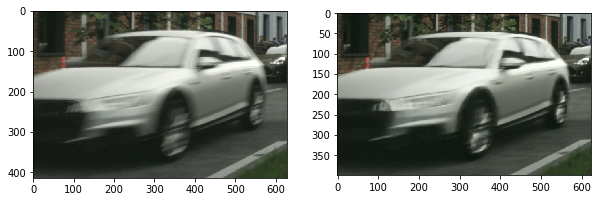

In [16]:
def test_on_image(image_path):
    # make the image the correct size
    blur_image = tf.image.decode_png(tf.io.read_file(image_path))[:, :, :3]
    test = tf.cast(blur_image, "float32")
    test = 2*test/255 - 1
    height, width = test.shape[0:2]
    width = (width//16)*16
    height = (height//16)*16
    test = tf.image.resize(test, (height, width))
    
    result = complete_model(test[tf.newaxis])
    result = result[0]

    
    # scale the output
    output = ((result+test+1)/2).numpy()
    output[output<0] = 0
    output[output>1] = 1
    output = (output*255).astype("uint8")
    
    return output

with tf.device("CPU:0"):
    output = test_on_image(file_name)
plt.figure(figsize=(10.0, 10.0))
plt.subplot(1, 2, 1)
plt.imshow(plt.imread(file_name))
plt.subplot(1, 2, 2)
plt.imshow(output)

output_location = ""
# plt.imsave(output_location, output)

### Testing on entire folder

In [ ]:
test_folder = ""
if "results" not in os.listdir(test_folder):
        os.mkdir(os.path.join(test_folder, "results"))


for file in os.listdir(test_folder):
    if os.path.isfile(test_folder + file):
        print("File name : ", file)
        output_image = test_on_image(test_folder + file)
        plt.imsave(test_folder + "results/" + file[:-4] + "_result" + file[-4:], output_image)

### Really random stuff

In [ ]:
file_name = "test images/suspect_images/blur/test_7.jpg"
output = test_on_image(file_name)
plt.imsave("test images/suspect_images/blur/results/test_7_result.jpg", output)

In [ ]:
blur_image = tf.image.decode_png(tf.io.read_file(file_name))[:, :, :3]
# image_paths_blur_test[image_no]
# clear_image = tf.image.decode_png(tf.io.read_file(image_paths_clear_test[image_no]))

test = tf.cast(blur_image, "float32")
test = 2*test/255 - 1
height, width = test.shape[0:2]
width = (width//16)*16
height = (height//16)*16
# test = test[height//3:height//2, 0:width//2]
test = tf.image.resize(test, (height//2, width//2))
# test = tf.image.resize(test, (144, 256))

# test_result = tf.cast(clear_image, "float32")
# test_result = 2*test_result/255 - 1
# test_result = tf.image.resize(test_result, (144, 256))
# test, test_result = data[0][5], data[1][5]
result = complete_model.predict(test[tf.newaxis])[0]
# test_new = test + result
# result = complete_model.predict(test_new[tf.newaxis])[0]

plt.figure(figsize=(20.0, 20.0))
plt.subplot(1, 2, 1)
plt.imshow((test+1)/2)
plt.subplot(1, 2, 2)
plt.imshow((result+test+1)/2)
# plt.subplot(1, 3, 3)
# plt.imshow((test_result+1)/2)

In [ ]:
plt.figure(figsize=(10.0, 10.0))
plt.imshow((result+2)/4)

In [ ]:
plt.imshow((test_result-test+2)/4)

In [ ]:
complete_model.save_weights("weights/weight_custom_0.3")

In [ ]:
# %timeit -n 5 complete_model(data[0])

In [ ]:
tf.keras.load_model("weights/comlpete_model_0.40")

In [ ]:
import cv2

In [ ]:
output = ((result+test+1)/2).numpy()
output[output<0] = 0
output[output>1] = 1
output = (output*255).astype("uint8")
plt.imshow(output)
plt.imsave("test images/suspect_images/blur/test_5_result.jpg", output)